In [201]:
#!/usr/bin/env python

# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Xinlei Chen, based on code from Ross Girshick
# --------------------------------------------------------

"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""
# %matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

from model.config import cfg
from model.test import im_detect
from torchvision.ops import nms

from utils.timer import Timer
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1

import torch

import datetime

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('vgg16_faster_rcnn_iter_%d.pth',),'res101': ('res101_faster_rcnn_iter_%d.pth',)}
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


In [2]:
def transform_bird_eye_view(img):
    IMAGE_H = img.shape[0]
    IMAGE_W = img.shape[1]
    
    src = np.float32([[0, IMAGE_H], [IMAGE_W, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    dst = np.float32([[246, IMAGE_H], [IMAGE_W-246, IMAGE_H], [0, 0], [IMAGE_W, 0]])
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    Minv = cv2.getPerspectiveTransform(dst, src) # Inverse transformation

    plt.imshow(img) # Show results
    warped_img = cv2.warpPerspective(img, M, (IMAGE_W, IMAGE_H)) # Image warping
    plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB)) # Show results
    plt.show()

In [3]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    
    if len(inds) == 0:
        return

    display(class_name, inds)

    
    im = im[:, :, (2, 1, 0)]
    
    fig, ax = plt.subplots(ncols=2, figsize=(24, 12))
#     fig.set_size_inches(np.shape(im)[0], np.shape(im)[1])
    ax[0].imshow(im, aspect='equal')
    ax[1].set(xlim=(0, np.shape(im)[1]), ylim=(np.shape(im)[0], 0), aspect='equal')
    fig.subplots_adjust(wspace=0.)
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
    
        display(bbox)
        
        ax[0].add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax[1].scatter(((bbox[0]+bbox[2])/2,), ((bbox[1]+bbox[3])/2, ), marker='d', s=20*4*5)
        ax[0].text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax[0].set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
#     plt.axis('off')
    plt.tight_layout()
    plt.draw()


In [4]:
demonet = 'res101' # Network to use [vgg16 res101]
dataset = 'pascal_voc_0712' # Trained dataset [pascal_voc pascal_voc_0712]

def load_module():
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals

    # model path
    saved_model = os.path.join('../output', demonet,
                              NETS[demonet][0] %(70000 if dataset == 'pascal_voc' else 110000))


    if not os.path.isfile(saved_model):
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(saved_model))

    # load network
    if demonet == 'vgg16':
        net = vgg16()
    elif demonet == 'res101':
        net = resnetv1(num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(21,
                          tag='default', anchor_scales=[8, 16, 32])

    net.load_state_dict(torch.load(saved_model, map_location=lambda storage, loc: storage))

    net.eval()
    if not torch.cuda.is_available():
        net._device = 'cpu'
    net.to(net._device)

    return net

In [63]:
NMS_THRESH = 0.3
CONF_THRESH = 0.8

def get_coords(net, image_name, categories, x_offset=0, y_offset=0):
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)
    
    scores, boxes = im_detect(net, im)
    
    result = dict()
    for category in categories:
        idx_boxes = boxes[:, 4*category:4*(category + 1)]
        idx_scores = scores[:, category]
        clean_idx = nms(torch.from_numpy(idx_boxes), torch.from_numpy(idx_scores), NMS_THRESH)
        valid_idxs = clean_idx.numpy()[np.where(idx_scores[clean_idx.numpy()] > CONF_THRESH)]
        valid_boxes = idx_boxes[valid_idxs]
        
        display(clean_idx)
        display(idx_scores[clean_idx])
        
        display(valid_idxs)
        display(valid_boxes)
        display(idx_scores[valid_idxs])
        
        result[category] = np.vstack((
            (x_offset + (valid_boxes[:, 0] + valid_boxes[:, 2]) / 2),
            (valid_boxes[:, 1] + valid_boxes[:, 3]) / 2)).T
        
    return result

In [135]:
def _append_coords(scores, boxes, categories, x_offset=0):
    result = dict()
    for category in categories:
        idx_boxes = boxes[:, 4*category:4*(category + 1)]
        idx_scores = scores[:, category]
        clean_idx = nms(torch.from_numpy(idx_boxes), torch.from_numpy(idx_scores), NMS_THRESH)
        valid_idxs = clean_idx.numpy()[np.where(idx_scores[clean_idx.numpy()] > CONF_THRESH)]
        valid_boxes = idx_boxes[valid_idxs]
        
        result[category] = np.vstack((
            (x_offset + (valid_boxes[:, 0] + valid_boxes[:, 2]) / 2),
            (valid_boxes[:, 1] + valid_boxes[:, 3]) / 2)).T
    return result

In [179]:
NMS_THRESH = 0.3
CONF_THRESH = 0.8

def get_coords(net, file_path, categories):
    im = cv2.imread(file_path)
    
    mid_x = im.shape[1]//2
    
    output = dict()
    for img, offset_x in zip((im[:, :mid_x], im[:, mid_x:]), (0, mid_x)):
        result = _append_coords(*im_detect(net, img), categories, offset_x)
        
        for k, v in result.items():
            if k not in output:
                output[k] = v
            else:
                output[k] = np.concatenate((output[k], v))
    return output

In [158]:
output = get_coords(net, "0000000000.png", target_classes)

In [6]:
IMAGE_H = 512
IMAGE_W = 1392

src = np.float32([[0, IMAGE_H], [IMAGE_W, IMAGE_H], [0, 0], [IMAGE_W, 0]])
dst = np.float32([[246, IMAGE_H], [IMAGE_W-246, IMAGE_H], [0, 0], [IMAGE_W, 0]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix

In [79]:
def transform_coords(coords):
    coords = np.pad(coords, ((0, 0), (0, 1)), mode="constant", constant_values=1)
    transformed = np.dot(M, coords.T)
    return transformed[:2] / transformed[-1]

In [65]:
target_classes = [7, 15]
display([CLASSES[tc] for tc in target_classes])

net = load_module()
left = get_coords(net, "0000000000_L.png",target_classes)
right = get_coords(net, "0000000000_R.png",target_classes, x_offset=670)

['car', 'person']

tensor([  0, 255, 215,  29, 104,  45,  43, 132, 106, 262, 144,  64, 108, 110,
        137, 116,  88,  80, 111,  32,  38, 249, 260,  39,  57, 109, 167, 263,
        226, 211, 172, 210, 245,   7, 155, 235, 268, 283, 293, 166])

array([9.98323858e-01, 3.09265524e-01, 7.32523724e-02, 2.86671836e-02,
       2.10452843e-02, 1.66030247e-02, 1.61476936e-02, 9.75899864e-03,
       8.68289359e-03, 6.82858936e-03, 6.76019397e-03, 6.33955840e-03,
       6.29828870e-03, 6.16901461e-03, 5.61765162e-03, 4.49140463e-03,
       4.19077929e-03, 3.35922465e-03, 2.61137960e-03, 2.39263847e-03,
       2.18716031e-03, 1.47296989e-03, 1.44787773e-03, 1.34116528e-03,
       8.49846692e-04, 7.86109245e-04, 5.76920807e-04, 4.75027104e-04,
       3.88473592e-04, 3.39305087e-04, 1.90037506e-04, 1.44996215e-04,
       1.08541695e-04, 8.49244534e-05, 8.37341431e-05, 6.24877866e-05,
       5.98800871e-05, 2.95228238e-05, 6.53191591e-06, 3.52571828e-06],
      dtype=float32)

array([0], dtype=int64)

array([[  0.     , 264.05902, 347.56348, 510.     ]], dtype=float32)

array([0.99832386], dtype=float32)

tensor([  1,   4, 243,  48, 275,  22,  44, 142,  32, 184, 138, 147, 144,  96,
        128, 228, 225, 136,  33, 107,  16, 106, 181, 244, 236,  77, 194, 109,
        126, 141, 290, 246, 177, 183,   7,  55,  84, 213, 268,  92, 282, 260,
        230, 296, 223, 293, 272, 299])

array([9.89080131e-01, 9.87479985e-01, 9.49581206e-01, 8.28658104e-01,
       5.87889671e-01, 2.18990862e-01, 2.16994151e-01, 2.03830600e-01,
       1.98680818e-01, 1.12270392e-01, 1.10961206e-01, 9.13866162e-02,
       7.74935186e-02, 6.01706877e-02, 5.52277938e-02, 5.21838777e-02,
       4.82469946e-02, 3.75890434e-02, 2.98524518e-02, 2.76762731e-02,
       2.02364530e-02, 1.79086737e-02, 1.67254489e-02, 1.28350426e-02,
       1.05014211e-02, 8.32958613e-03, 8.11901782e-03, 7.91029911e-03,
       4.60179616e-03, 3.07879318e-03, 2.31385860e-03, 1.97546836e-03,
       1.81277236e-03, 1.43402268e-03, 7.16614071e-04, 6.26587600e-04,
       4.93081752e-04, 1.98114343e-04, 1.84827513e-04, 1.60781507e-04,
       1.03868842e-04, 2.53585968e-05, 1.95797511e-05, 1.52551265e-05,
       3.72861632e-06, 1.84986413e-06, 1.07540507e-06, 5.63577260e-07],
      dtype=float32)

array([  1,   4, 243,  48], dtype=int64)

array([[492.41104 , 219.78981 , 519.61035 , 300.07788 ],
       [442.31058 , 225.30415 , 476.27914 , 305.0305  ],
       [ 33.000175, 248.21349 , 106.27773 , 307.1319  ],
       [ 39.417305, 327.0936  ,  84.49724 , 385.97586 ]], dtype=float32)

array([0.98908013, 0.98748   , 0.9495812 , 0.8286581 ], dtype=float32)

tensor([180, 261,  46,  96, 283,  75, 228, 286, 197,  89, 110,  90, 282, 134,
        272, 248, 262, 226, 260, 244, 133, 275,  34, 267, 231, 210, 277, 227,
        256,  81, 103, 295, 238, 167, 193, 232,  93, 250, 270, 150, 132])

array([9.8101175e-01, 5.9099227e-02, 2.5087204e-02, 1.1869159e-02,
       5.4329527e-03, 4.8784227e-03, 4.4569941e-03, 3.8473855e-03,
       3.3386843e-03, 2.1172978e-03, 1.0779583e-03, 1.0737794e-03,
       7.3480711e-04, 6.1142235e-04, 5.9364684e-04, 5.9170206e-04,
       4.1428694e-04, 3.9855865e-04, 3.6591166e-04, 3.5397211e-04,
       3.4260598e-04, 3.1487941e-04, 2.7504854e-04, 2.7142838e-04,
       2.5793500e-04, 2.1675004e-04, 1.3622762e-04, 1.2203613e-04,
       8.2137332e-05, 7.6081509e-05, 6.3376465e-05, 5.6298457e-05,
       5.5794066e-05, 2.7925456e-05, 1.0255880e-05, 8.7440721e-06,
       5.5610685e-06, 3.5672613e-06, 1.8312419e-06, 1.5492114e-06,
       1.0861862e-06], dtype=float32)

array([180], dtype=int64)

array([[293.88635, 217.73236, 510.72577, 313.63727]], dtype=float32)

array([0.98101175], dtype=float32)

tensor([  0,   1,   6,  46,  33, 170,  34,  75, 262,  59,  39, 229, 126, 110,
         96, 234,  49, 124,  90,  72, 148, 165, 197, 118, 246, 108,  82, 206,
        264, 200, 115, 272, 273, 278, 267, 133, 266, 144, 244, 213, 193,  88,
        154, 140])

array([9.93421257e-01, 9.75012779e-01, 9.35173154e-01, 3.62822562e-01,
       1.46330878e-01, 4.52388227e-02, 4.32312414e-02, 3.85730267e-02,
       3.30249742e-02, 2.41273083e-02, 1.48120131e-02, 1.44857699e-02,
       1.23579837e-02, 1.14668319e-02, 1.09128486e-02, 6.00989582e-03,
       4.52151475e-03, 3.07319942e-03, 2.99966102e-03, 1.58902595e-03,
       1.45111617e-03, 1.42744870e-03, 1.23600743e-03, 9.43497929e-04,
       9.26378591e-04, 9.01740859e-04, 7.86300167e-04, 7.82925636e-04,
       6.27756759e-04, 6.06249261e-04, 1.89116719e-04, 1.80646239e-04,
       1.42986915e-04, 1.04625928e-04, 1.04295556e-04, 8.70936128e-05,
       7.27297374e-05, 6.65574044e-05, 6.32452866e-05, 1.37226389e-05,
       1.01548840e-05, 8.50424203e-06, 8.21877529e-06, 6.14711735e-06],
      dtype=float32)

array([0, 1, 6], dtype=int64)

array([[193.65887 , 215.4292  , 261.3422  , 391.95184 ],
       [ 54.655304, 220.63626 ,  86.99585 , 303.73715 ],
       [137.84206 , 211.94705 , 163.95149 , 299.681   ]], dtype=float32)

array([0.99342126, 0.9750128 , 0.93517315], dtype=float32)

In [67]:
output = dict()
for tc in target_classes:
    output[tc] = np.concatenate([d[tc] for d in (left, right)])

In [68]:
display(output)

{7: array([[ 173.78174,  387.0295 ],
        [1072.306  ,  265.6848 ]], dtype=float32),
 15: array([[506.01068 , 259.93384 ],
        [459.29486 , 265.16733 ],
        [ 69.638954, 277.6727  ],
        [ 61.95727 , 356.53473 ],
        [897.50055 , 303.69052 ],
        [740.82556 , 262.1867  ],
        [820.8968  , 255.81403 ]], dtype=float32)}

In [180]:
def show_image(im_path):
    im = cv2.imread(im_path)
    
    fig, ax = plt.subplots(figsize=(24, 24))
    ax.imshow(im, aspect='equal')
    
    plt.axis('off')
    plt.tight_layout()
    
    plt.draw()

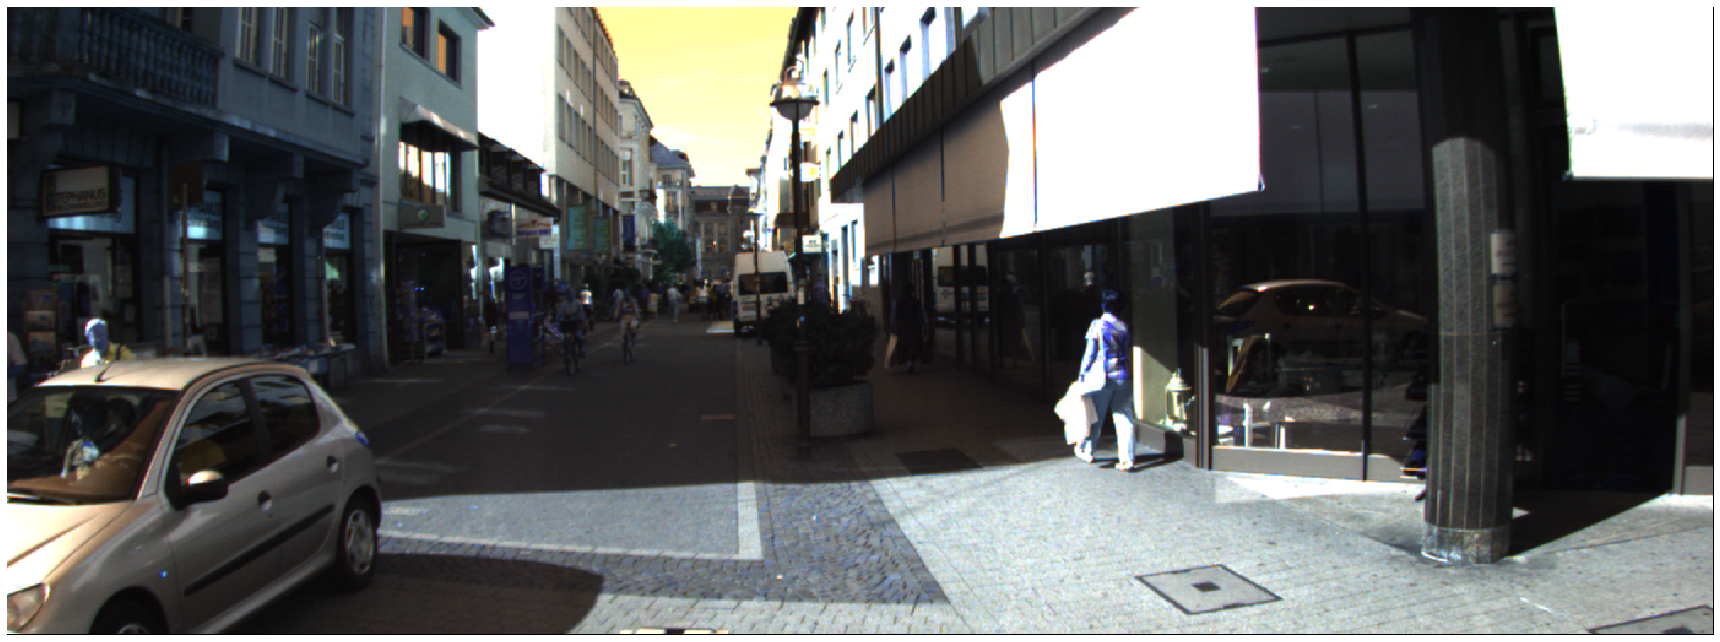

In [167]:
show_image("0000000000.png")

In [71]:
display(*output[7].T)

array([ 173.78174, 1072.306  ], dtype=float32)

array([387.0295, 265.6848], dtype=float32)

In [203]:
def draw_points(coords):
    fig, ax = plt.subplots(figsize=(24, 24), facecolor="black")
    ax.set(xlim=(0, IMAGE_W), ylim=(IMAGE_H, 0), aspect='equal')    
    
    for category, coord in coords.items():
        marker, size = ('d', 80) if category == 7 else ('o', 40)
        ax.scatter(*transform_coords(coord), marker=marker, s=size*20, c="white")
        
    plt.axis('off')
    plt.tight_layout()
#     plt.draw()
    
    plt.savefig(f'{datetime.datetime.now().timestamp()}.png', bbox_inches='tight', facecolor="black")
    plt.close(fig)

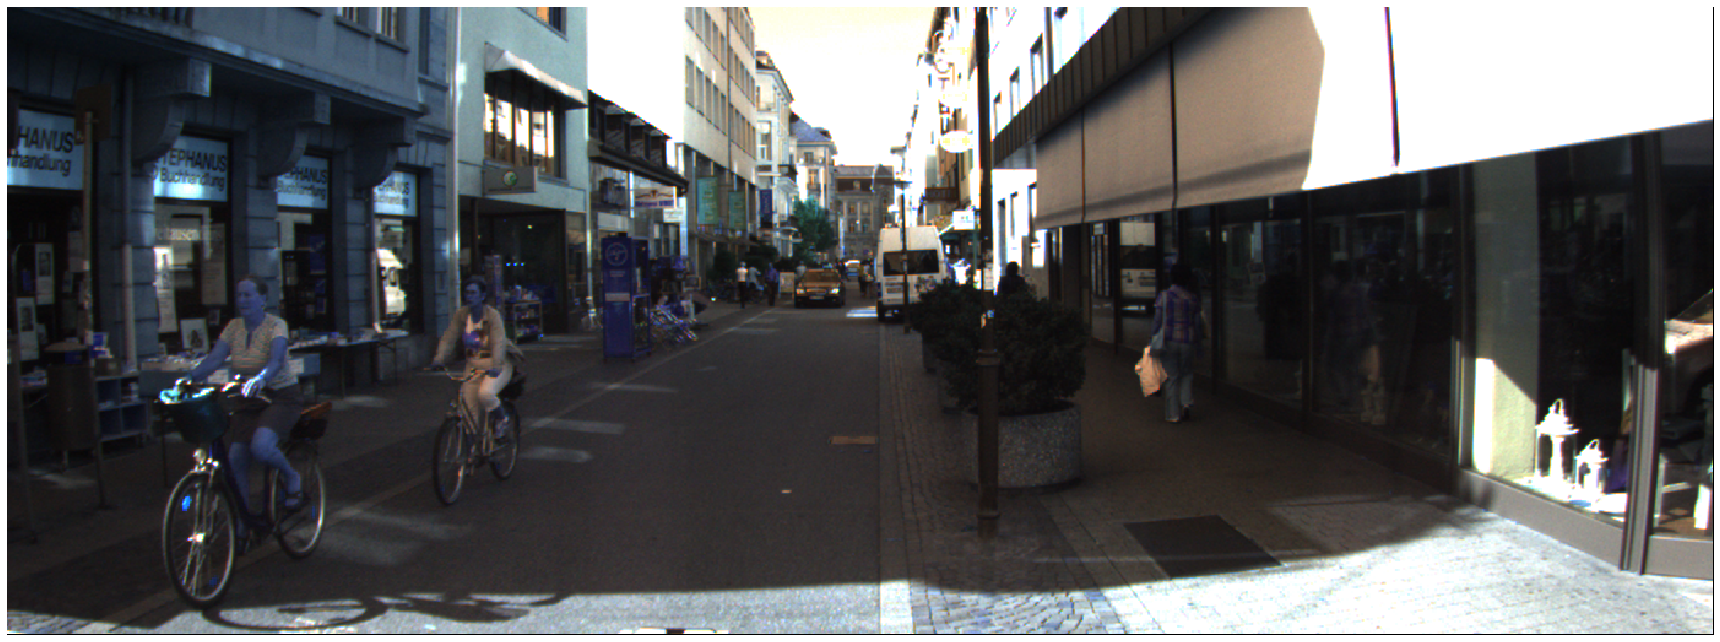

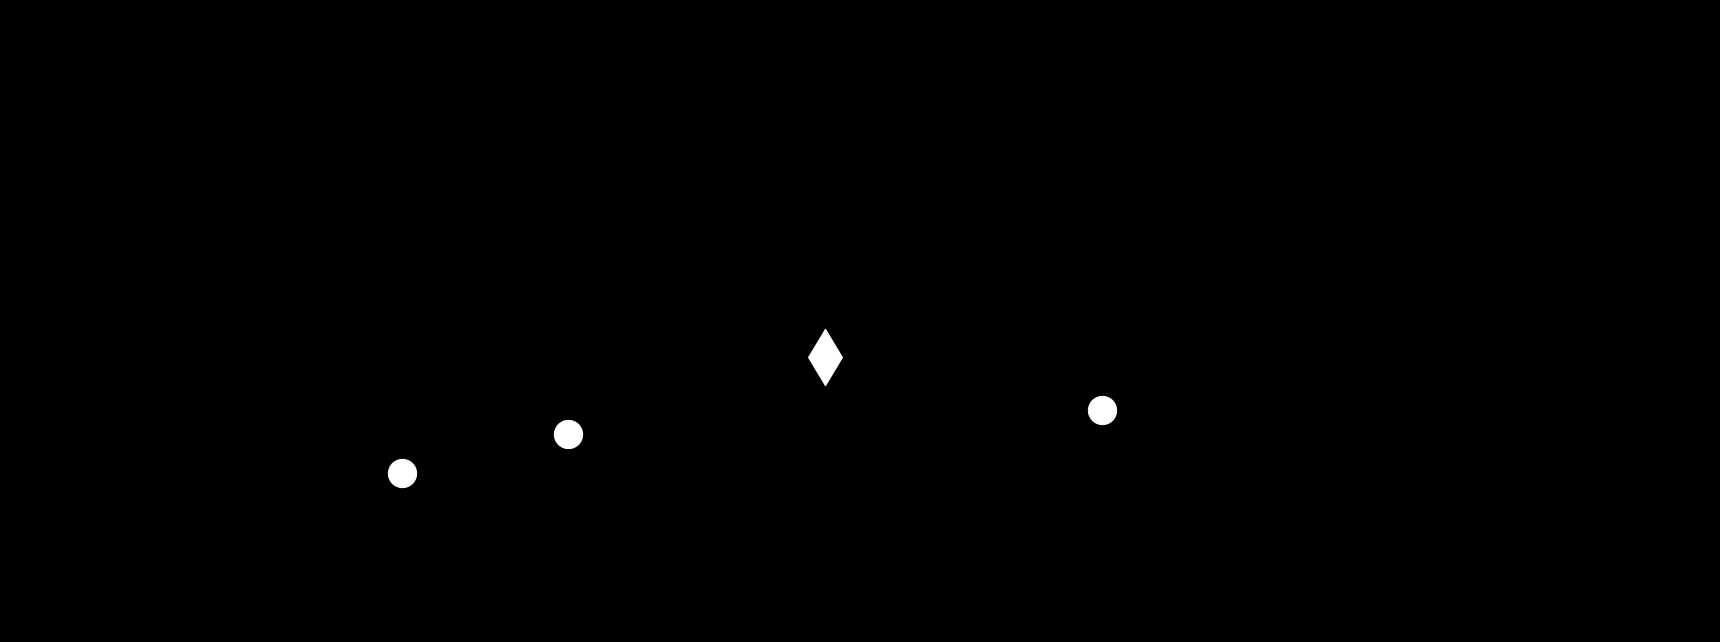

In [171]:
# draw_points(output[15].T)
# transformed = transform_coords(output[15])

# display(transformed)
img_name = "0000000040.png"


show_image(img_name)

output = get_coords(net, img_name, target_classes)
draw_points(output)

In [122]:
im_file = os.path.join(cfg.DATA_DIR, 'demo', "0000000000.png")
im = cv2.imread(im_file)

mid_x = im.shape[1]//2
left, right = im[:, :mid_x], im[:, mid_x:]
ims = np.array([left, right])

In [124]:
scores, boxes = im_detect(net, ims[0])

In [205]:
f = []
for (dirpath, dirnames, filenames) in os.walk(os.path.join(cfg.DATA_DIR, 'demo', "111")):
    for f in filenames:
        im_file = os.path.join(cfg.DATA_DIR, 'demo', '111', f)
#         show_image(im_file)

        output = get_coords(net, im_file, target_classes)
        draw_points(output)

In [186]:
datetime.datetime.now().timestamp()

1573707915.186382